## Applied Machine Learning Homework 2
### Task 1
Po-Chieh Liu

pl2441

In [1]:
# import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import sklearn packages
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# warning issue
import warnings
warnings.filterwarnings("ignore")

#### Import data
Use pandas to import data. **Order** and **PID** columns are dropped. I assume both columns are not related to sale prices.

In [2]:
# import data using pandas read_excel
df = pd.read_excel('AmesHousing.xls')
df.drop(columns=['Order','PID'], inplace =True)

#### Feature lists
Based on the data document page, lists of continuous, discrete and categorical features are created. For my understanding, both ordinal and nominal variables are categorical variable, thus both two types variables are used for categorical tasks.

There are 20 continuous features including target "SalePrice", 14 discrete features, and rest are categorical features.

http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [3]:
# continuous feature list, total 20 continuous features
cts_list = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 
            'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', 
            '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area',
            'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 
            'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice']

# discrete feature list, total 14 discrete features
dis_list = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 
            'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 
            'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 
            'Mo Sold', 'Yr Sold']

# create categorical index list
cat_list = [el for el in df.columns if el not in cts_list + dis_list]

#### Data quality check
Check the data information. There are some missing values which will be addressed later.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 80 columns):
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       

## Task 1.1

#### Visualize the univariate distribution of each continuous, and the distribution of the target. Do you notice anything? Is there something that might require special treatment?

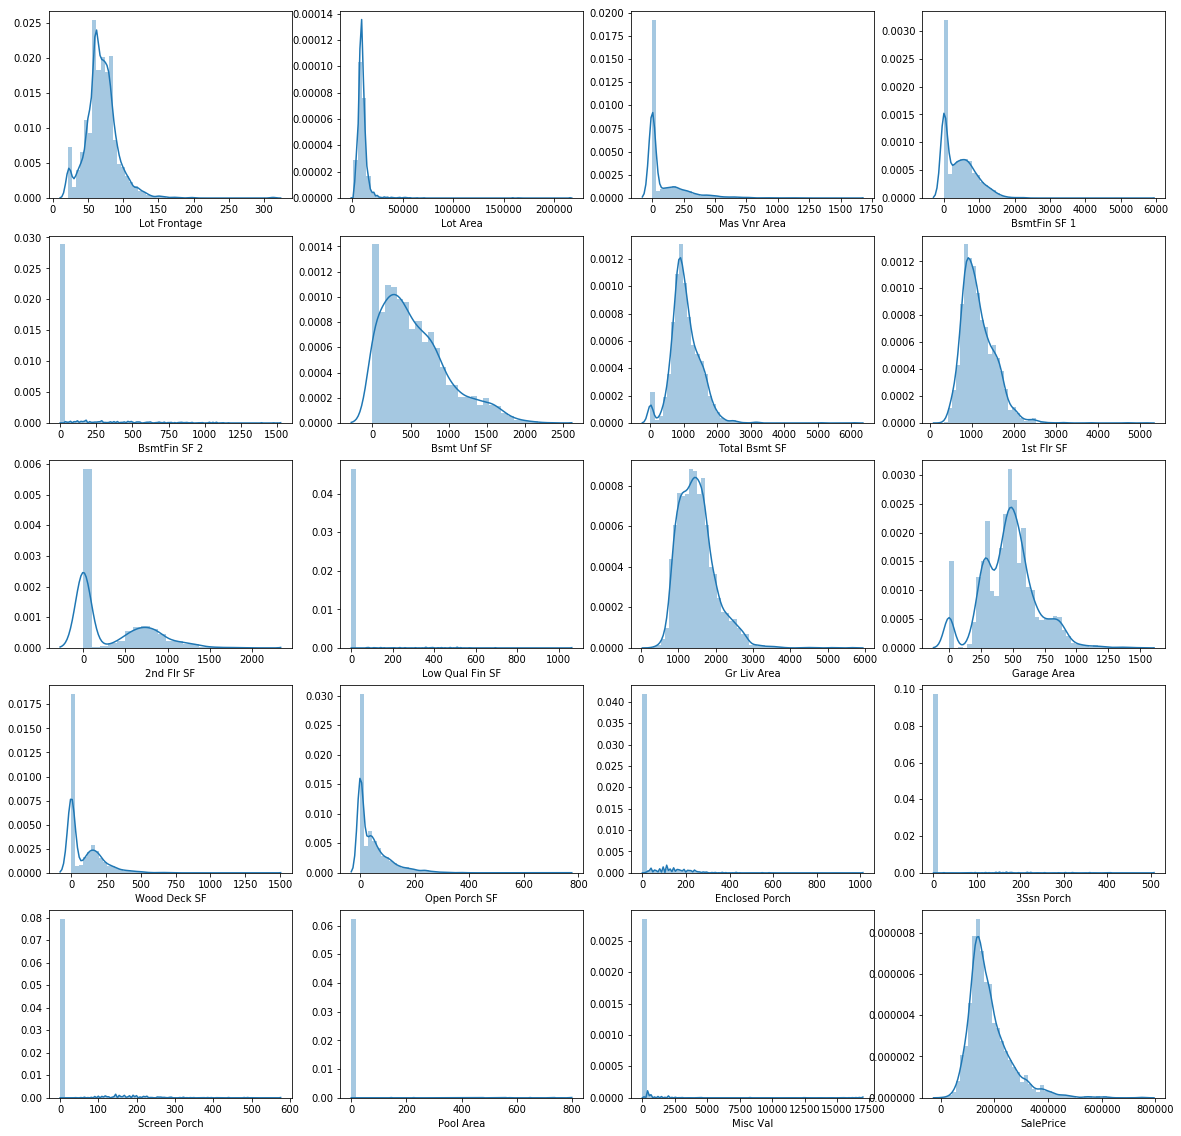

In [5]:
# extract continuous data
df_cts = df[cts_list].copy()

# generate plot using sns
# note, missing values are ignored in task 1.1
fig1, axes1 = plt.subplots(5, 4, figsize = (20,20))
axis1 = axes1.flatten()
for i in range(len(axis1)):
    sns.distplot(df_cts[cts_list[i]].dropna(), ax = axis1[i])

#### Task 1.1 answer:
From the distribution plots, some characteristics are found: 

First we can observe the **scale** differences between features. For example, *Lot Frontage* varies from $0$ to $350$ and *Lot Area* varies from $0$ to $200,000$. Therefore, the **standardization** step is required for using continuous features to build model.

Second, some features have majority data located on 0 and have long tails with relatively small amount data points. For example, *BsmtFin SF 2*, *Low Qual Fin SF*, *Enclosed Porch*, *3Ssn Porch*, *Screen Porch*, *Pool Area*, and *Misc Val*. We should apply **power transformation** to adjust the imbalanced features. 

Third, some features show bimodal on plots, including *Lot Frontage* , *Mas Vnr Area* , *BsmtFin SF 1* , *Total Bsmt SF* , *2nd Fir SF*, *Wood Deck SF* and *Open Porch SF*. *Garage Area* shows multimodal trend on plot.

## Task 1.2

#### Visualize the dependency of the target on each continuous feature (2d scatter plot).

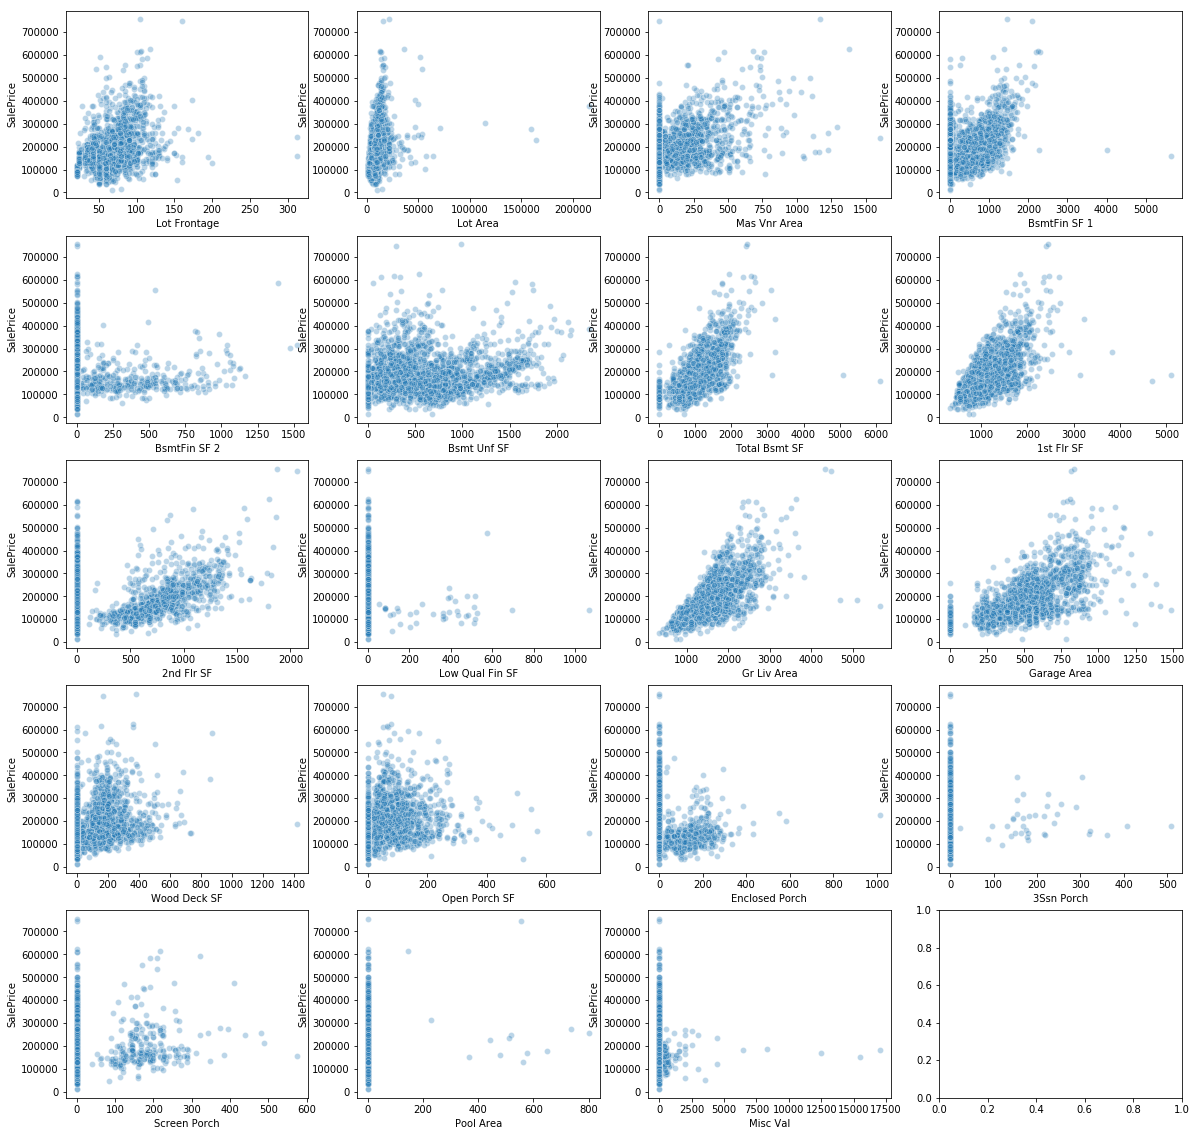

In [6]:
# generate plots using sns
fig2, axes2 = plt.subplots(5, 4, figsize = (20,20))
axis2 = axes2.flatten()
for i in range(19):
    sns.scatterplot(x = cts_list[i], y = cts_list[-1], 
                    data = df_cts[[cts_list[i], cts_list[-1]]], 
                    ax = axis2[i], alpha = 0.3)

## Task 1.3

#### Split data in training and test set. Do not use the test-set unless for a final evaluation in 1.6. For each categorical variable, cross-validate a Linear Regression model using just this variable (one-hot-encoded). Visualize the relationship of the categorical variables that provide the best $R^2$ value with the target.

In [7]:
# train test split
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[:,0:-1], 
                                                    df[cts_list[-1]])

# preprocess Y_train buy subtracting y mean
Y_preprocessed = Y_train - Y_train.mean()

In [8]:
# function for cross validate categorical data with y using linear model
def cv_lr_ohe_cat(X, y, pipe):
    X_temp = X.values.reshape(-1, 1)
    return np.mean(cross_val_score(pipe, X_temp, y, cv = 10))

In [9]:
# categorical imputer
cat_imp = SimpleImputer(missing_values=np.nan, strategy='constant')

# initiate best score recorder 
max_score, max_cat = 0, '' 

# initiate pipe, including imputer, one-hot-encoder and lr
pipe = make_pipeline(cat_imp, 
                     OneHotEncoder(handle_unknown='ignore', sparse=False), 
                     LinearRegression())

# loop through categorical features
for idx in cat_list:
    cv_score = cv_lr_ohe_cat(X_train[idx],Y_preprocessed, pipe)
    if cv_score > max_score: max_score, max_cat = cv_score, idx
    print(idx + ' cross validation score: ' + str(cv_score))

# print out best score feature
print('\n' + '"' + str(max_cat) + '"' +  
      ' has max training score: ' + 
      str(max_score))

MS SubClass cross validation score: 0.23966354366748233
MS Zoning cross validation score: 0.10816716984052639
Street cross validation score: -0.0019955731247021657
Alley cross validation score: 0.017941410728646735
Lot Shape cross validation score: 0.08497012829715002
Land Contour cross validation score: 0.026538086114146087
Utilities cross validation score: -0.006404056827039162
Lot Config cross validation score: 0.01440026918334687
Land Slope cross validation score: -0.006607346883382348
Neighborhood cross validation score: -4.870921091283519e+21
Condition 1 cross validation score: 0.03180873014935894
Condition 2 cross validation score: -8.98061557546615e+23
Bldg Type cross validation score: 0.02452680814752125
House Style cross validation score: 0.0674952230751122
Overall Qual cross validation score: 0.7022900157521258
Overall Cond cross validation score: 0.1414535147507699
Roof Style cross validation score: 0.05921283933600262
Roof Matl cross validation score: -1.263204525102729e+2

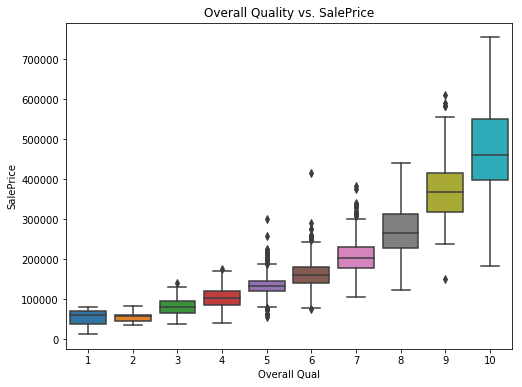

In [10]:
# visulize the max score feature vs sale price
fig = plt.figure(figsize = (8,6))
_ = sns.boxplot(x = max_cat, y = cts_list[-1], 
                data = pd.concat([X_train[max_cat], Y_train], 
                axis=1, join='inner'))
_ = plt.title('Overall Quality vs. SalePrice')

## Task 1.4

#### Use ColumnTransformer and pipeline to encode categorical variables. Evaluate Linear Regression (OLS), Ridge, Lasso and ElasticNet using cross-validation with the default parameters. Does scaling the data (within the pipeline) with StandardScaler help?

In [11]:
"""
Using mean, mode and constant to fill missing values of 
continuous, discrete, and categrocial variables, respectively.
"""
# initiate imputers
cts_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
dis_imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cat_imp = SimpleImputer(missing_values=np.nan, strategy='constant')
# impute
X_train[cts_list[:-1]] = cts_imp.fit_transform(X_train[cts_list[:-1]])
X_train[dis_list] = dis_imp.fit_transform(X_train[dis_list])
X_train[cat_list] = cat_imp.fit_transform(X_train[cat_list])
# check
assert X_train.isnull().sum().sum() == 0

In [12]:
# column transformer contains 
# power transformer for continuous variables 
# and onehotencoder for categorical variabes
preprocess = make_column_transformer(
    (PowerTransformer(method = 'yeo-johnson'), cts_list[:-1]),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_list), 
    remainder='passthrough')

# pipes with and without standard scalar
# linear
linear_pipe = make_pipeline(preprocess, LinearRegression())
linear_pipe_S = make_pipeline(preprocess, StandardScaler(), LinearRegression())
# ridge
ridge_pipe = make_pipeline(preprocess, Ridge())
ridge_pipe_S = make_pipeline(preprocess, StandardScaler(), Ridge())
# lasso
lasso_pipe = make_pipeline(preprocess, Lasso())
lasso_pipe_S = make_pipeline(preprocess, StandardScaler(), Lasso())
# elastic
elastic_pipe =  make_pipeline(preprocess, ElasticNet())
elastic_pipe_S =  make_pipeline(preprocess, StandardScaler(), ElasticNet())

# put together
pipe_list = {'linear': [linear_pipe, linear_pipe_S], 
             'ridge': [ridge_pipe, ridge_pipe_S],
             'lasso': [lasso_pipe, lasso_pipe_S],
             'elastic': [elastic_pipe, elastic_pipe_S]}

In [13]:
# test all pipes
for key, pipe in pipe_list.items():
    print(key + ' model average score: ' + 
          str(np.mean(cross_val_score(pipe[0], X_train, Y_preprocessed, cv=10))))
    print(key + ' model with scalar score: '+
          str(np.mean(cross_val_score(pipe[1], X_train, Y_preprocessed, cv=10))))
    print()

linear model average score: -8603104476129498.0
linear model with scalar score: -4.377534577849754e+23

ridge model average score: 0.8726156388760898
ridge model with scalar score: 0.8564045729243925

lasso model average score: 0.8576133680940279
lasso model with scalar score: 0.8565106775478541

elastic model average score: 0.8075723857562995
elastic model with scalar score: 0.8682916312140267



#### Task 1.4 answer:
Based on the modeling results, the **StandardScaler** made the linear regression score increased from order $-1*10^{15}$ to order $-1*10^{23}$. For Ridge the score slightly dropped around 0.02 after adding **StandardScaler**. For Lasso and ElasticNet, the scores improved after adding **StandardScaler**.

Note, the scores are different each time I ran the code.

## Task 1.5

#### Tune the parameters of the models using GridSearchCV. Do the results improve? Visualize the dependence of the validation score on the parameters for Ridge, Lasso and ElasticNet.

In [14]:
# for variable dimension consistency, 
# use same input data for all three models (task 1.6)
X_preprocessed = preprocess.fit_transform(X_train)

#### Ridge

In [15]:
# parameter to search
param_grid = {'alpha': np.logspace(-2, 3, 16)}

# search
grid_ridge = GridSearchCV(Ridge(), param_grid, cv=10)
grid_ridge.fit(X_preprocessed, Y_preprocessed)

# result
print(grid_ridge.best_params_)
print(grid_ridge.best_score_)

{'alpha': 10.0}
0.8682140076436017


In [16]:
# function for generate result plot
def result_plot(result, title, xlabel, ylabel):
    # initiate figure
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(1, 1, 1)

    # training CI
    ax.fill_between(result.param_alpha.astype(float), 
                (result.mean_train_score.astype(float) + 
                 result.std_train_score.astype(float)), 
                (result.mean_train_score.astype(float) - 
                 result.std_train_score.astype(float)),
                color = 'b',
                alpha=0.25)
    
    # training score
    ax.semilogx(result.param_alpha,
            result.mean_train_score,
            'bo-',
            label='training set CV score with Std.')
    
    # testing CI
    ax.fill_between(result.param_alpha.astype(float),
                (result.mean_test_score.astype(float) + 
                 result.std_test_score.astype(float)), 
                (result.mean_test_score.astype(float) - 
                 result.std_test_score.astype(float)),
                color = 'g',
                alpha=0.25)
    
    # testing score            
    ax.semilogx(result.param_alpha,
            result.mean_test_score,
            'go-',
            label='testing set CV score with Std.')
    
    # plot setup
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    _ = plt.legend(loc = 3)

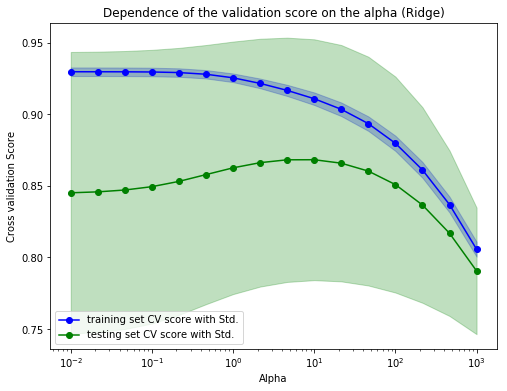

In [17]:
# extract Ridge grid search result
result = pd.DataFrame(grid_ridge.cv_results_)

# generate plot
result_plot(result,
            'Dependence of the validation score on the alpha (Ridge)',
            'Alpha',
            'Cross validation Score')

#### Lasso

In [18]:
# parameter to search
param_grid = {'alpha': np.logspace(-2, 3, 16)}

# search
grid_lasso = GridSearchCV(Lasso(), param_grid, cv=10)
grid_lasso.fit(X_preprocessed, Y_preprocessed)

# result
print(grid_lasso.best_params_)
print(grid_lasso.best_score_)

{'alpha': 100.0}
0.8678121486775051


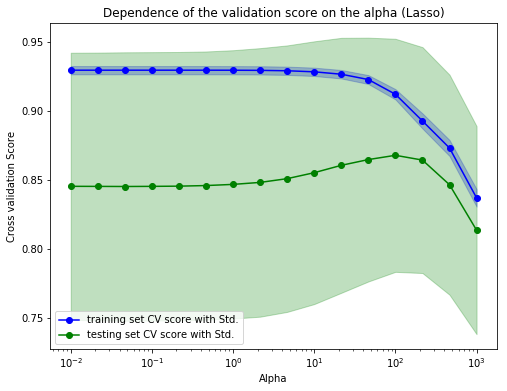

In [19]:
# extract result
result = pd.DataFrame(grid_lasso.cv_results_)

# generate plot
result_plot(result,
            'Dependence of the validation score on the alpha (Lasso)',
            'Alpha',
            'Cross validation Score')

#### Elastic

In [20]:
# parameter to search 
param_grid = {'alpha': np.logspace(-3, 3, 16),
              'l1_ratio': [0.01, .1, .5, .9, .98, 1]}

# search
grid_elastic = GridSearchCV(ElasticNet(), param_grid, cv=10)
grid_elastic.fit(X_preprocessed, Y_preprocessed)

# result
print(grid_elastic.best_params_)
print(grid_elastic.best_score_)

{'alpha': 0.039810717055349734, 'l1_ratio': 0.9}
0.8684379353113347


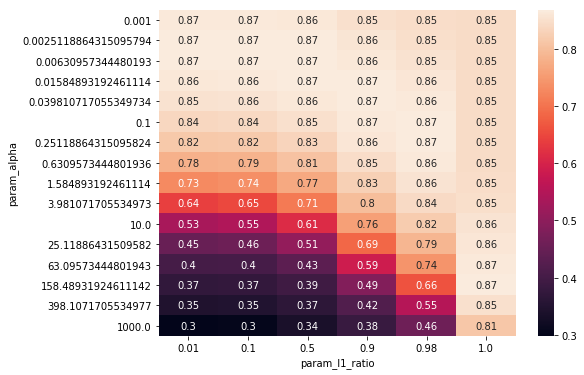

In [21]:
# extract result
result = pd.pivot_table(pd.DataFrame(grid_elastic.cv_results_),
                        values='mean_test_score', 
                        index='param_alpha', 
                        columns='param_l1_ratio')

# visulize result using heat map
fig = plt.figure(figsize = (8,6))
ax = sns.heatmap(result, annot=True)

#### Task 1.5 answer:

In general, the grid search results have comparable scores for Ridge and Lasso models. For ElasticNet, the score is improved and close to adding standard scalar. 

Note, the StandardScalar is not applied in task 1.5 due to the comparison task of 1.6.

## Task 1.6

#### Visualize the coefficients of the resulting models. Do they agree on which features are important?

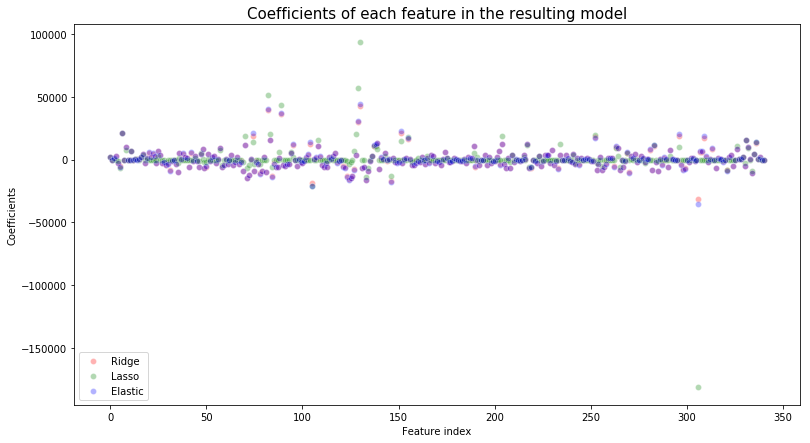

In [22]:
# best parameter
best_ridge = grid_ridge.best_estimator_
best_lasso = grid_lasso.best_estimator_
best_elastic = grid_elastic.best_estimator_

#
fig = plt.figure(figsize = (13,7))
sns.scatterplot(range(X_preprocessed.shape[1]), 
                best_ridge.coef_ , 
                label='Ridge', 
                alpha = 0.3, 
                color = 'r')
sns.scatterplot(range(X_preprocessed.shape[1]), 
                best_lasso.coef_ , 
                label='Lasso', 
                alpha = 0.3, 
                color = 'g')
sns.scatterplot(range(X_preprocessed.shape[1]), 
                best_elastic.coef_ , 
                label='Elastic', 
                alpha = 0.3, 
                color = 'b')
# adjust
_ = plt.title('Coefficients of each feature in the resulting model',size=15)
_ = plt.xlabel('Feature index')
_ = plt.ylabel('Coefficients')
_ = plt.legend(loc = 3)

#### Task 1.6 answer:

From the plot, we can observe all three models performed like we expected. Ridge has lots non-zero weights due to L2 penalty. Lasso has lots zero weights and some large weights in compared with Ridge. ElasticNet weights are close to Ridge model’s weights. Overall, all three models agree with what are the important features correlated to SalePrice. 

Note, for some runs, the ElasticNet weights are much similar to Lasso instead of Ridge.

Next three plots are separated plots of 0~109, 110~219, and 220 to the end for reading the details.

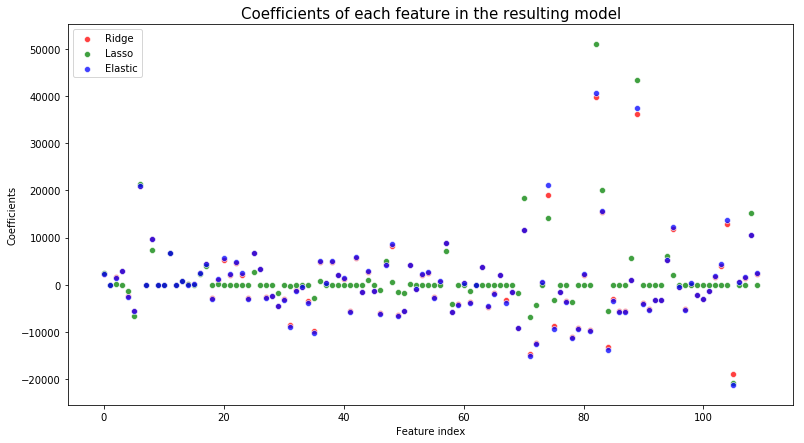

In [23]:
#
fig = plt.figure(figsize = (13,7))
sns.scatterplot(range(110), 
                best_ridge.coef_[:110] , 
                label='Ridge', 
                alpha = 0.75, 
                color = 'r')
sns.scatterplot(range(110), 
                best_lasso.coef_[:110] , 
                label='Lasso', 
                alpha = 0.75, 
                color = 'g')
sns.scatterplot(range(110), 
                best_elastic.coef_[:110] , 
                label='Elastic', 
                alpha = .75, 
                color = 'b')
# adjust
_ = plt.title('Coefficients of each feature in the resulting model',size=15)
_ = plt.xlabel('Feature index')
_ = plt.ylabel('Coefficients')
_ = plt.legend(loc = 2)

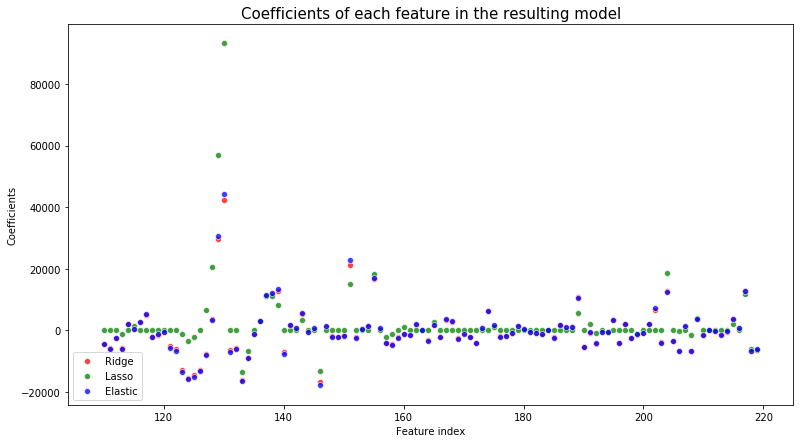

In [24]:
#
fig = plt.figure(figsize = (13,7))
sns.scatterplot(range(110,220), 
                best_ridge.coef_[110:220] , 
                label='Ridge', 
                alpha = 0.75, 
                color = 'r')
sns.scatterplot(range(110,220), 
                best_lasso.coef_[110:220] , 
                label='Lasso', 
                alpha = 0.75, 
                color = 'g')
sns.scatterplot(range(110,220), 
                best_elastic.coef_[110:220] , 
                label='Elastic', 
                alpha = 0.75, 
                color = 'b')
# adjust
_ = plt.title('Coefficients of each feature in the resulting model',size=15)
_ = plt.xlabel('Feature index')
_ = plt.ylabel('Coefficients')
_ = plt.legend(loc = 3)

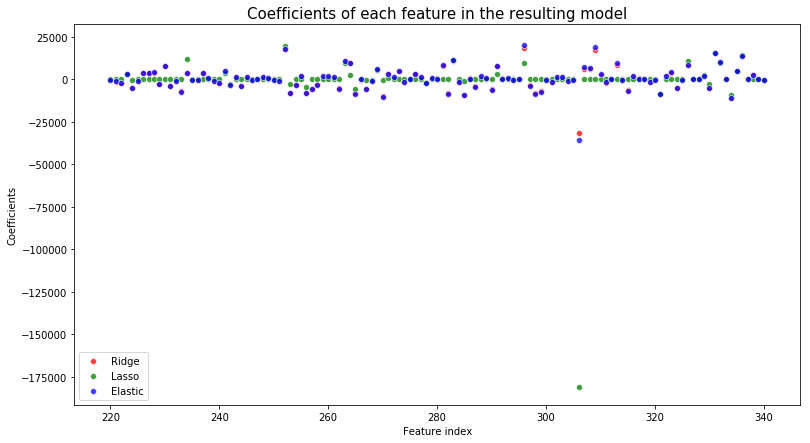

In [25]:
#
fig = plt.figure(figsize = (13,7))
sns.scatterplot(range(220,X_preprocessed.shape[1]), 
                best_ridge.coef_[220:] , 
                label='Ridge', 
                alpha = 0.75, 
                color = 'r')
sns.scatterplot(range(220,X_preprocessed.shape[1]), 
                best_lasso.coef_[220:] , 
                label='Lasso', 
                alpha = 0.75, 
                color = 'g')
sns.scatterplot(range(220,X_preprocessed.shape[1]), 
                best_elastic.coef_[220:] , 
                label='Elastic', 
                alpha = 0.75, 
                color = 'b')
# adjust
_ = plt.title('Coefficients of each feature in the resulting model',size=15)
_ = plt.xlabel('Feature index')
_ = plt.ylabel('Coefficients')
_ = plt.legend(loc = 3)

#### Note for simulation results

Every time I rerun the code, the result might converge to different minimum. The scores in each sections might change. Also in the last section, the ElasticNet coefficient results sometimes are similar to Ridge, and sometimes are close to Lasso.